## １. ライブラリのインポート
以下を実行してライブラリをインポート

In [2]:
import serial
import csv
import os
from datetime import datetime
import threading
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd

## 2. ファイル名の設定
出力されるCSVとPNGのファイル名を設定

student_idとsuffixを仕様に合わせて設定

In [3]:
student_id = '026'      #自分の学籍番号の下3桁を設定
top_threshold = 0       #Arduinoのプログラムで設定したTOP_THRESHOLDの値を設定する
down_threshold = 4      #Arduinoのプログラムで設定したDOWN_THRESHOLDの値を設定する

file_name = f'b2_{student_id}_top{top_threshold}_down{down_threshold}' #上記の設定により自動でファイル名が設定される

## ３. シリアル通信によるデータの読み込み
port='/dev/tty'の y と ' の間にカーソルを合わせ . を入力すると候補が表示されるので，usbmodem.....を選択
実行後にArduinoからの信号待ち状態に入る

eを入力し，Enterで終了するとそれまでにArudinoから送信されたデータがファイルに出力される

In [ ]:
#################### シリアルポートの設定 #########################
##修正箇所：ttyの後ろに.を入力すると候補が表示されるのでusbmodemの方を選択（数値は各々のMacやArduinoによって異なる）
##例：ser = serial.Serial(port='/dev/tty.usbmodem4827E2E0D9D02', baudrate=115200, timeout=1) 
##ser = serial.Serial(port='/dev/tty.usbmodem34B7DA61F2202', baudrate=115200, timeout=1) 

# 以前のシリアルポートをクローズ（既に接続されている場合）
try:
    if 'ser' in locals() and ser.is_open:
        ser.close()
except:
    pass

ser = serial.Serial(port='/dev/tty.usbmodem34B7DA61F2202', baudrate=115200, timeout=1) 


###################  これ以降は修正の必要はない  ###################
data = []
exit_flag = False

def save_to_csv(data):
    with open(f'{file_name}.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(data)    

def log_to_file(port):
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")[:-3]  # ミリ秒まで取得
    log_data = [current_time, port, file_name]
    log_file = f'b2_{student_id}_log.csv'
    try:
        with open(log_file, 'x', newline='') as log:
            writer = csv.writer(log)
            writer.writerow(["Timestamp", "Port", "OutputFile"])  # ヘッダー行
            writer.writerow(log_data)
    except FileExistsError:
        with open(log_file, 'a', newline='') as log:
            writer = csv.writer(log)
            writer.writerow(log_data)
            
def read_serial():
    global exit_flag

    while not exit_flag:
        if ser.in_waiting > 0:
            
            line = ser.readline().decode('utf-8').rstrip()
            print(line, flush=True)

            parsed_line = line.replace('",', ',').replace('"', '')
            parts = parsed_line.split(',')
            
            if len(parts) == 3:
                data.append([parts[0].strip(), parts[1].strip(), parts[2].strip()])

def wait_for_exit():
    global exit_flag
    while not exit_flag:
        # キー入力を待機
        if input() == 'e':
            exit_flag = True
            save_to_csv(data)
            log_to_file(ser.port)
            print("終了キーが押されました。データを保存して終了します。")

print("シリアル通信の読み込み開始，Arduinoのリセットボタンを押して下さい．", flush=True)
print("ArduinoのTX LEDが消灯後，eを入力しEnterで終了し，ファイルが出力されます", flush=True)

input_thread = threading.Thread(target=wait_for_exit)
input_thread.start()
read_serial()
input_thread.join()
ser.close()

SerialException: [Errno 16] could not open port /dev/tty.usbmodem34B7DA61F2202: [Errno 16] Resource busy: '/dev/tty.usbmodem34B7DA61F2202'

## ４. 図の描画

CSVの出力を元にグラフを作成して画像ファイル(PNG形式)で出力する
2. ファイル名の設定で設定した名前に基づいてcsvの読み込みと，pngの出力が行われる

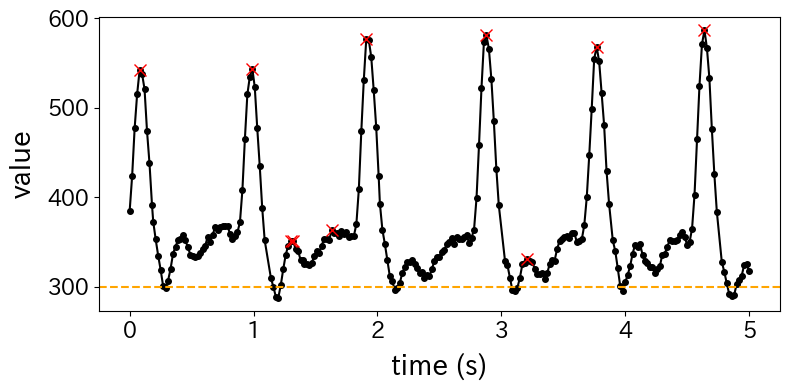

In [19]:
fig = plt.figure(figsize=(8, 4))
ax = fig.subplots()

data = pd.read_csv(f"{file_name}.csv")  

t = data['time'].values
v = data['value'].values

ax.plot(t, v, marker='o', color='#000000', linestyle="-", markersize=4)

peak_t = data['time'][data['peak'] == 1].values
peak_v = data['value'][data['peak'] == 1].values
ax.plot(peak_t, peak_v, marker='x', color='red', linestyle='None', markersize=8, label='Peak')

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.xaxis.labelpad = 8
ax.yaxis.labelpad = 8
ax.axhline(y=top_threshold, linestyle='--', linewidth=1.5,
           color='orange', label=f'top_threshold={top_threshold}')
ax.set_xlabel("time (s)", fontsize=20)
ax.set_ylabel("value", fontsize=20)

plt.tight_layout()
plt.savefig(f"{file_name}.png") 
plt.show()